In [18]:
"""
Brendan Lauterborn
ALS Matrix Factorization for Movie Recommendations
Data Citation:
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context.
ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19.
https://doi.org/10.1145/2827872
"""


# Install
!pip install -q implicit

# Download the dataset
!curl -L https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

# Unzip
import zipfile
with zipfile.ZipFile('ml-latest-small.zip', 'r') as z:
    z.extractall('.')

# Imports
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.model_selection import train_test_split
import implicit

# Load data
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')

# Split
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  1507k      0 --:--:-- --:--:-- --:--:-- 1509k


In [19]:
user_map = {u: i for i, u in enumerate(ratings_df['userId'].unique())}
item_map = {m: i for i, m in enumerate(ratings_df['movieId'].unique())}

rows = ratings_df['userId'].map(user_map)
cols = ratings_df['movieId'].map(item_map)
vals = ratings_df['rating']


# Encode IDs as indices
# Training matrix
rows_train = train_df['userId'].map(user_map)
cols_train = train_df['movieId'].map(item_map)
vals_train = train_df['rating']
Ui_train = coo_matrix((vals_train, (rows_train, cols_train)),
                      shape=(len(user_map), len(item_map)))

# Test matrix
rows_test = test_df['userId'].map(user_map)
cols_test = test_df['movieId'].map(item_map)
vals_test = test_df['rating']
Ui_test = coo_matrix((vals_test, (rows_test, cols_test)),
                     shape=(len(user_map), len(item_map)))

# Create sparse user-item matrix
user_item = coo_matrix((vals, (rows, cols)))

user_item.shape

(610, 9724)

In [20]:
from implicit.als import AlternatingLeastSquares
# Convert to confidence weigts
alpha = 15
confidence = (user_item * alpha).astype('double')

# Train the model
model = AlternatingLeastSquares(
    factors=20,
    regularization=0.1,
    iterations=20,
    random_state=42
)
model.fit(confidence)


/usr/local/lib/python3.12/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004288673400878906 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
# Convert to CSR for fast row access
confidence_csr = confidence.tocsr()

user_id = 0
recommended = model.recommend(user_id, confidence_csr[user_id])


In [22]:
# --- Metric functions ---
def precision_at_k_manual(model, train_user_items, test_user_items, K=10):
    train_user_items = train_user_items.tocsr()
    test_user_items  = test_user_items.tocsr()
    precisions = []
    for user in range(train_user_items.shape[0]):
        if train_user_items[user].nnz == 0:
            continue
        test_items = test_user_items[user].indices
        if len(test_items) == 0:
            continue
        rec_ids, _ = model.recommend(
            user,
            train_user_items[user],
            N=K,
            filter_already_liked_items=True
        )
        hits = len(set(rec_ids) & set(test_items))
        precisions.append(hits / K)
    return np.mean(precisions) if precisions else 0.0


def recall_at_k(model, train_user_items, test_user_items, K=10):
    train_user_items = train_user_items.tocsr()
    test_user_items  = test_user_items.tocsr()
    recalls = []
    for user in range(train_user_items.shape[0]):
        if train_user_items[user].nnz == 0:
            continue
        test_items = test_user_items[user].indices
        if len(test_items) == 0:
            continue
        rec_ids, _ = model.recommend(
            user,
            train_user_items[user],
            N=K,
            filter_already_liked_items=True
        )
        hits = len(set(rec_ids) & set(test_items))
        recalls.append(hits / len(test_items))
    return np.mean(recalls) if recalls else 0.0


def map_at_k_manual(model, train_user_items, test_user_items, K=10):
    train_user_items = train_user_items.tocsr()
    test_user_items  = test_user_items.tocsr()
    maps = []
    for user in range(train_user_items.shape[0]):
        if train_user_items[user].nnz == 0:
            continue
        test_items = set(test_user_items[user].indices)
        if not test_items:
            continue
        rec_ids, _ = model.recommend(
            user,
            train_user_items[user],
            N=K,
            filter_already_liked_items=True
        )
        hits = 0
        precisions = []
        for i, rec in enumerate(rec_ids):
            if rec in test_items:
                hits += 1
                precisions.append(hits / (i + 1))
        maps.append(np.mean(precisions) if precisions else 0.0)
    return np.mean(maps) if maps else 0.0


def ndcg_at_k_manual(model, train_user_items, test_user_items, K=10):
    train_user_items = train_user_items.tocsr()
    test_user_items  = test_user_items.tocsr()
    ndcgs = []
    for user in range(train_user_items.shape[0]):
        if train_user_items[user].nnz == 0:
            continue
        test_items = set(test_user_items[user].indices)
        if not test_items:
            continue
        rec_ids, _ = model.recommend(
            user,
            train_user_items[user],
            N=K,
            filter_already_liked_items=True
        )
        dcg = 0.0
        for i, rec in enumerate(rec_ids):
            if rec in test_items:
                dcg += 1.0 / np.log2(i + 2.0)
        idcg = sum(1.0 / np.log2(i + 2.0) for i in range(min(len(test_items), K)))
        ndcgs.append(dcg / idcg if idcg > 0 else 0.0)
    return np.mean(ndcgs) if ndcgs else 0.0


# --- Convert train/test to CSR once ---
Ui_train_csr = Ui_train.tocsr()
Ui_test_csr  = Ui_test.tocsr()

# --- Evaluate for different K values ---
K_values = [5, 10, 20]
results = []

for K in K_values:
    precision = precision_at_k_manual(model, Ui_train_csr, Ui_test_csr, K)
    recall    = recall_at_k(model, Ui_train_csr, Ui_test_csr, K)
    mapk      = map_at_k_manual(model, Ui_train_csr, Ui_test_csr, K)
    ndcg      = ndcg_at_k_manual(model, Ui_train_csr, Ui_test_csr, K)
    results.append({
        "K": K,
        "Precision": precision,
        "Recall": recall,
        "MAP": mapk,
        "NDCG": ndcg
    })

metrics_df = pd.DataFrame(results)
display(metrics_df)

,K,Precision,Recall,MAP,NDCG
0,5,0.138361,0.072225,0.224797,0.139679
1,10,0.135410,0.131151,0.235879,0.155011
2,20,0.128279,0.221826,0.224859,0.191267


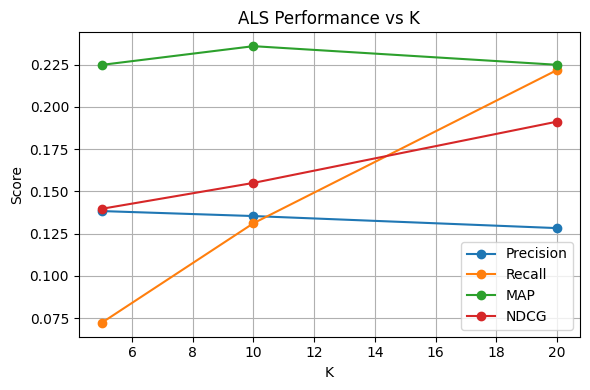

In [23]:
import matplotlib.pyplot as plt

# Line chart of all metrics vs K
fig = plt.figure(figsize=(6,4))
for col in ["Precision", "Recall", "MAP", "NDCG"]:
    plt.plot(metrics_df["K"], metrics_df[col], marker="o", label=col)

plt.xlabel("K")
plt.ylabel("Score")
plt.title("ALS Performance vs K")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




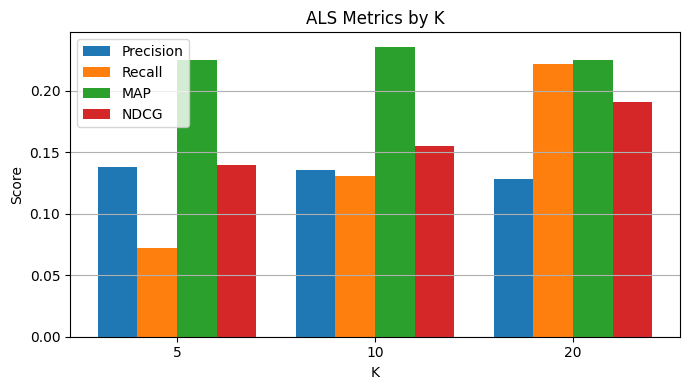

In [24]:
import numpy as np
labels = metrics_df["K"].astype(str).tolist()
x = np.arange(len(labels))
width = 0.2

fig = plt.figure(figsize=(7,4))
plt.bar(x - 1.5*width, metrics_df["Precision"], width, label="Precision")
plt.bar(x - 0.5*width, metrics_df["Recall"],    width, label="Recall")
plt.bar(x + 0.5*width, metrics_df["MAP"],       width, label="MAP")
plt.bar(x + 1.5*width, metrics_df["NDCG"],      width, label="NDCG")

plt.xticks(x, labels)
plt.xlabel("K")
plt.ylabel("Score")
plt.title("ALS Metrics by K")
plt.grid(axis="y")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:

# (Optional) GitHub metadata fix
try:
    import nbformat, os
    for f in os.listdir("/content"):
        if f.endswith(".ipynb"):
            path = f"/content/{f}"
            nb = nbformat.read(path, as_version=nbformat.NO_CONVERT)
            if "widgets" in nb.metadata:
                del nb.metadata["widgets"]
                nbformat.write(nb, path)
                print(f"Cleaned metadata in {f}")
except Exception as e:
    print(f"Skipped metadata cleaning: {e}")
